In [1]:
%matplotlib inline

In [2]:
# for helper functions, refer to the module dataset_exploration in the helper package
from helper.dataset_exploration import *

# 1. load dataset
The dataset is available in the release of the repository, see https://github.com/toinsson/touchclass/releases. Download the files and extract them in the `./dataset` folder.

The dataset includes 12 video recordings of 2 separated classes (touch and non-touch) from two different view angles (close and far, or S4 and S3, respectively) of different 3 finger types (index, thumb and pinky).

In [3]:
datafolder = './dataset/'
df = pd.read_csv(datafolder+'dataset.pd', index_col=0)

In [4]:
df

,user,surface,finger,class,filename,time
0,user_0,S3,index,touch,0.hdf5,2017-03-08_10:48:36
1,user_0,S3,index,notouch,1.hdf5,2017-03-08_10:50:27
2,user_0,S3,thumb,touch,2.hdf5,2017-03-08_10:52:53
3,user_0,S3,thumb,notouch,3.hdf5,2017-03-08_10:54:12
4,user_0,S3,pinky,touch,4.hdf5,2017-03-08_10:55:51
5,user_0,S3,pinky,notouch,5.hdf5,2017-03-08_10:56:57
6,user_0,S4,index,touch,6.hdf5,2017-03-08_11:01:13
7,user_0,S4,index,notouch,7.hdf5,2017-03-08_11:02:24
8,user_0,S4,thumb,touch,8.hdf5,2017-03-08_11:03:39
9,user_0,S4,thumb,notouch,9.hdf5,2017-03-08_11:04:52


Each file in the dataset is in the format hdf5 and contains a data group with 900 depth images of shape with time stamps and frame number, as well as some additional information needed to transform depth images into pointcloud:

- matrix: homography matrix
- origin: origin of the interaction surface
- extrema: boundaries of the interaction surface in pattern coordinates

The video was recorded with a marker in sight, as is common with AR techniques, to indicate the placement of the interactive plane. An homography was computed between the camera and this pattern.

In [5]:
f0 = df.iloc[10]['filename']
hf = h5py.File(datafolder+f0, 'r')

In [6]:
from IPython.display import display, Markdown

In [7]:
display(Markdown(hdf5_to_md(hf)))

<table>
        <tr>
        <th>name</th>
        <th>shape</th>
        <th>dtype</th>
        </tr>
    <tr>
        <td>data/depth</td>
        <td>(900, 480, 640)</td>
        <td>int16</td>
    </tr>
    <tr>
        <td>data/frame</td>
        <td>(900,)</td>
        <td>int64</td>
    </tr>
    <tr>
        <td>data/time</td>
        <td>(900,)</td>
        <td>|S26</td>
    </tr>
    <tr>
        <td>extrema</td>
        <td>(4,)</td>
        <td>float64</td>
    </tr>
    <tr>
        <td>matrix</td>
        <td>(3, 3)</td>
        <td>float32</td>
    </tr>
    <tr>
        <td>origin</td>
        <td>(3,)</td>
        <td>float32</td>
    </tr>
    <tr>
        <td>pattern</td>
        <td>()</td>
        <td>object</td>
    </tr>
    </table>

# 2. visualise dataset

## a. plot depth

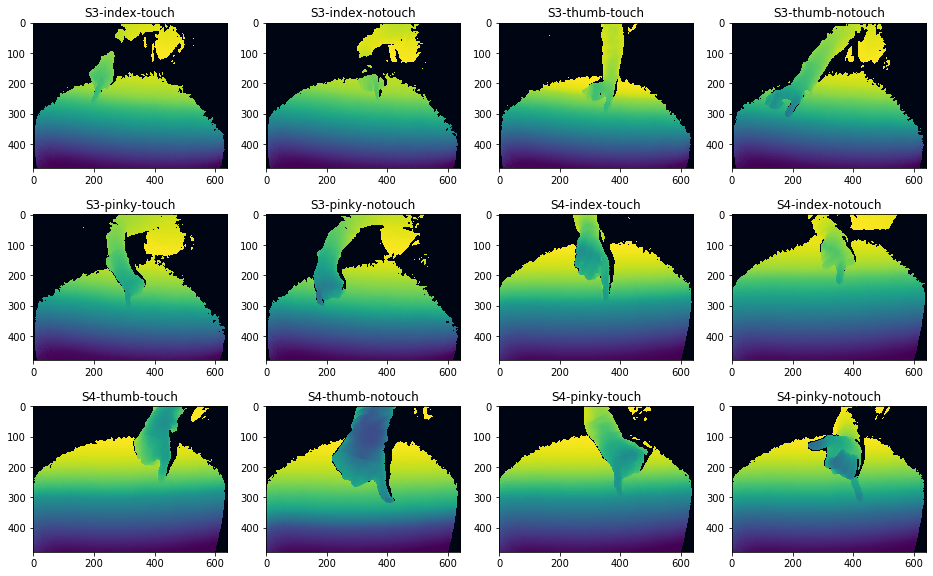

In [8]:
fig, axs = plt.subplots(3,4, figsize=(16,10))

# select the frame id in (0, 899)
image_id = 500

for i, row in df.iterrows():
    
    idx = np.unravel_index(i, (3,4))
    with h5py.File(datafolder+row['filename'], 'r') as hf:
        frame = hf['data/depth'][image_id]
        frame[0,0] = frame[0,1] = 0
    
    rgb_frame = int16_to_rgb(frame)
    axs[idx].imshow(rgb_frame)
    axs[idx].set_title("-".join(row[['surface', 'finger', 'class']].values))

In [9]:
from IPython.display import display
from ipywidgets import interactive
import ipywidgets as widgets

In [10]:
def f(dataset, frame_number):
    fig, ax = plt.subplots(figsize=(16,12))

    with h5py.File(datafolder+df.iloc[dataset]['filename'], 'r') as hf:
        frame = hf['data/depth'][frame_number]
        frame[0,0] = frame[0,1] = 0
    
    rgb_frame = int16_to_rgb(frame)
    ax.imshow(rgb_frame)
    ax.set_title("-".join(df.iloc[dataset][['surface', 'finger', 'class']].values))

w = interactive(f,
                dataset=widgets.IntSlider(min=0, max=11, step=1, value=0, continuous_update=False),
                frame_number=widgets.IntSlider(min=0, max=899, step=1, value=10, continuous_update=False))

In [11]:
display(w)

interactive(children=(IntSlider(value=0, continuous_update=False, description='dataset', max=11), IntSlider(va…

## b. deproject images

The images in the datasets are only the depth images. This information can however be transformed as a pointcloud if the intrinsic parameters of the camera are known. These were saved during the recording of the dataset.

In [12]:
from helper import vtkplot
from helper.deproject import deproject

In [13]:
filename = row['filename']

with h5py.File(datafolder+filename, 'r') as hdf5file:
    X = hdf5file['data/depth'][image_id]
    org = np.array(hdf5file['origin'], dtype=np.float32)
    mat = np.array(hdf5file['matrix'], dtype=np.float32)
    ext = np.array(hdf5file['extrema'], dtype=np.float32)

In [14]:
def transform(X, mat, org):
    # from camera coordinates to pattern coordinates
    return np.dot(mat, (X - org).reshape((-1,3)).T).T

def filter_(pc, ext):
    # restrict to the interactive surface
    xm = (pc[:,0] >= ext[0]) & (pc[:,0] <= ext[1])
    ym = (pc[:,1] >= ext[2]) & (pc[:,1] <= ext[3])
    return pc[xm & ym]

def compute(X, mat, org, ext):
        pc = deproject.compute(X)
        X = transform(pc, mat, org)
        X = filter_(X, ext)
        return X

In [15]:
res = compute(X, mat, org, ext)

In [16]:
# press Q to exit the visualisation
# axis shows 10cm in each directions
vtkplot.plot_objects(10*res, axis=True)